# Projet Finance, juin 2017

Oscar CLIVIO, Jean-Christophe CORVISIER

In [2]:
# Modules importés

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import erf
from scipy.stats import norm



In [3]:
#fonction qui simule un brownien
def MouvementBrownien(t):
    if t>0.0:
        valeur_proba=np.random.normal(0,np.sqrt(t))
        return valeur_proba 
    else:
        return 0
    
#retourne la valeur de l'actif risqué 
def calcul_actif(S0,sigma,r,t):
    Wt=MouvementBrownien(t)
    valeur_actif=S0*np.exp(sigma*Wt+(r - sigma**2 / 2)*t)
    return valeur_actif

#fonction de payoff
def payoff(K,liste_sigma,r,liste_S0,T,liste_an):
    Sum=0
    for i in range(len(liste_sigma)):
        Sum=Sum+calcul_actif(liste_S0[i],liste_sigma[i],r,T)*liste_an[i]
    return max(K-Sum,0)

def payoffProd(K,liste_sigma,r,liste_S0,T,liste_an):
    Prod=1
    for i in range(len(liste_sigma)):
        Prod=Prod*np.exp(liste_an[i]*np.log(calcul_actif(liste_S0[i],liste_sigma[i],r,T)));
    return max(K-Prod,0)

#fonction qui retourne le prix de l'option avec moyenne géométrique
def prixExpliciteGeometrique(K,liste_sigma,r,liste_S0,T,liste_an):
    
    def normal(x):
        return norm.cdf(x);
    
    Esp = liste_an.T.dot(np.log(liste_S0) - liste_sigma**2 * T/2) + r*T;
    Std = np.sqrt(T*(liste_an**2).dot(liste_sigma**2));
    
    d = (np.log(K) - Esp) / Std;
    
    return np.exp(-r*T)*(K*normal(d) - np.exp(Esp + Std**2 / 2.) * normal(d - Std));

#fonction retournant la valeur exacte de la variance de l'option avec moyenne geometrique        
def varianceExpliciteGeometrique(K,liste_sigma,r,liste_S0,T,liste_an):
    
    def normal(x):
        return norm.cdf(x);
    
    Esp = liste_an.T.dot(np.log(liste_S0) - liste_sigma**2 * T/2) + r*T;
    Std = np.sqrt(T*(liste_an**2).dot(liste_sigma**2));
    
    d = (np.log(K) - Esp) / Std;
    
    return np.exp(-2*r*T)*(K**2 * normal(d) + np.exp(2*Esp + 2*Std**2) * normal(d - 2*Std) - 2*K*np.exp(Esp + Std**2 / 2.) * normal(d - Std)) - prixExpliciteGeometrique(K,liste_sigma,r,liste_S0,T,liste_an)**2;
        


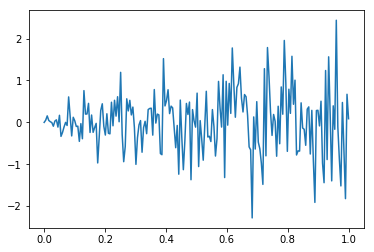

In [4]:
#Trajectoire du mouvement brownien
vecteur_x=np.linspace(0,1,200)
vecteur_y=[]
for i in range(200):
    vecteur_y.append(MouvementBrownien(vecteur_x[i]))
    

plt.plot(vecteur_x,vecteur_y)
plt.show()

In [8]:
#valeur numériques pour les simulations
an=np.array([1./5.]*5);
S0=np.array([10,20,30,40,50]);
K=max(np.prod(np.exp(np.log(S0)/5.)),an.T.dot(S0))
print("K = Max(" + str(np.prod(np.exp(np.log(S0)/5.))*1.2) + "," + str(an.T.dot(S0)*0.8) + ")")
K=31
N=50000
r=0.05
sigma=np.array([0.1,0.05,0.06,0.07,0.1]);
T=1.0

#fonction qui retourne les valeur de N realisations de l'option avec 
#moyenne arithmétique
def realisationsMonteCarloArith(K,sigma,r,S0,T,an,N):
    realisations = []
    for i in range(N):
        realisations.append(np.exp(-r*T)*payoff(K,sigma,r,S0,T,an))
    return np.array(realisations)

#fonction qui retourne les valeurs de N realisations de l'option avec
#moyenne geometrique
def realisationsMonteCarloGeo(K,sigma,r,S0,T,an,N):
    realisations = []
    for i in range(N):
        realisations.append(np.exp(-r*T)*payoffProd(K,sigma,r,S0,T,an))
    return np.array(realisations)

#retourne l'estimateur de Monte Carlo avec les fonctions de realisations 
#precedentes
def estimateurMonteCarlo(realisations):
    return realisations.mean();


#estimation empirique de la variance par Monte Carlo
def estimateurVarianceMonteCarlo(realisations, estimateurEsperance):
    return (realisations**2).mean() - estimateurEsperance**2;

#estimation de la variance par reduction en utilisant la variable de controle
def estimateurVarianceReduiteMonteCarlo(realisationsGeo, realisationsArith, estimateurbn, prixExactGeo, estimateurEsperance):
    return ((realisationsArith + estimateurbn*(realisationsGeo - prixExactGeo))**2).mean() - estimateurEsperance**2;

#estimateur de la variable de controle
def estimateur_bn(realisationsGeo,realisationsArith,prixExactGeo,estimateurArith):
    diffGeo = realisationsGeo - prixExactGeo;
    return diffGeo.T.dot(realisationsArith-estimateurArith)/np.sum(diffGeo**2)

#estimateur du prix de l'option avec moyenne arithmetique par reduction de variance
def estimateurTotal(realisationsGeo,realisationsArith,prixExactGeo):
    estimateurGeo = estimateurMonteCarlo(realisationsGeo);
    estimateurArith = estimateurMonteCarlo(realisationsArith);
    estimateurbn = estimateur_bn(realisationsGeo,prixExpliciteGeometrique(K,liste_sigma,r,liste_S0,T,liste_an))
    return estimateurArith + estimateurbn*(estimateurGeo - prixExactGeo)

#fonction d'affichage de l'evolution des estimateurs des prix avec et sans
#reduction de variance, ainsi que l'evolution des variances calculees
def reductionVariance(K,sigma,r,S0,T,an,N):
    realisationsArith = realisationsMonteCarloArith(K,sigma,r,S0,T,an,N)
    realisationsGeo = realisationsMonteCarloGeo(K,sigma,r,S0,T,an,N);
    prixExactGeo = prixExpliciteGeometrique(K,sigma,r,S0,T,an)
    varianceExacteGeo = varianceExpliciteGeometrique(K,sigma,r,S0,T,an)
    
    esperanceInitiale = estimateurMonteCarlo(realisationsArith);
    estimateurbn = estimateur_bn(realisationsGeo,realisationsArith,prixExactGeo,esperanceInitiale)
    esperanceReduite = esperanceInitiale + estimateurbn*(estimateurMonteCarlo(realisationsGeo) - prixExactGeo)
    

    #print(estimateurbn)
    #print(estimateurVarianceMonteCarlo(realisationsGeo, estimateurMonteCarlo(realisationsGeo)))
    #print(varianceExacteGeo)
    
    varianceInitiale = estimateurVarianceMonteCarlo(realisationsArith, esperanceInitiale)
    varianceReduite = varianceInitiale*(1-estimateurbn**2*varianceExacteGeo/varianceInitiale);
    
    #print("Esperance initiale: ", esperanceInitiale)
    #print("Esperance réduite: ", esperanceReduite)
    #print("Variance initiale: ", varianceInitiale)
    #print("Variance réduite: ", varianceReduite)
    return esperanceReduite
    
    

def simulation_monte_carlo(N):
    Sum=0
    for i in range(N):
        Sum+=payoff(K,sigma,r,S0,T,an)
    return np.exp(-r*T)*Sum/N

def simulation_monte_carlo_Prod(N):
    Sum=0
    for i in range(N):
        Sum+=payoffProd(K,sigma,r,S0,T,an)
    return np.exp(-r*T)*Sum/N


K = Max(31.2620530164,24.0)


In [11]:

print("Prix explicite, moyenne géométrique", prixExpliciteGeometrique(K,sigma,r,S0,T,an))
print("Prix simulé, moyenne géométrique", simulation_monte_carlo_Prod(N))
print("Prix simulé, moyenne arithmétique", simulation_monte_carlo(N))
print("Prix simulé, moyenne arithmétique, variance réduite", reductionVariance(K,sigma,r,S0,T,an,N))

('Prix explicite, moyenne g\xc3\xa9om\xc3\xa9trique', 3.5009693604744632)
('Prix simul\xc3\xa9, moyenne g\xc3\xa9om\xc3\xa9trique', 3.5077395921221441)
('Prix simul\xc3\xa9, moyenne arithm\xc3\xa9tique', 0.26896075887764209)
('Prix simul\xc3\xa9, moyenne arithm\xc3\xa9tique, variance r\xc3\xa9duite', 0.27095538611913067)


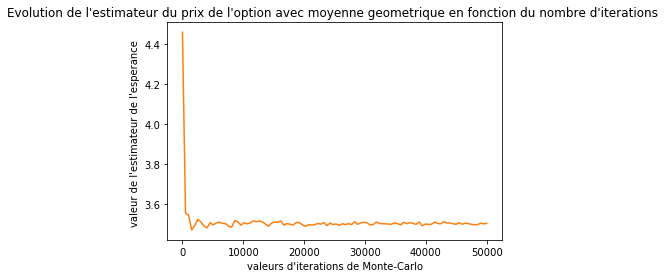

In [13]:
#trace de la courbe d'evolution de l'estimation
#du prix avec moyenne geometrique
#en fonction du nombre d'iterations de Monte Carlo
vecteur_x=np.linspace(1,50001,100)
vecteur_y=[]

for i in range(100):
    vecteur_y.append(estimateurMonteCarlo(realisationsMonteCarloGeo(K,sigma,r,S0,T,an,int(vecteur_x[i]))))
plt.plot(vecteur_x,vecteur_y,linewidth=1.5, linestyle="-", label=("trajectoire de l'estimateur de l'esperance"))
plt.ylabel("valeur de l'estimateur de l'esperance ")
plt.xlabel("valeurs d'iterations de Monte-Carlo")
plt.title("Evolution de l'estimateur du prix de l'option avec moyenne geometrique en fonction du nombre d'iterations ")
plt.show()
    

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning: invalid value encountered in double_scalars


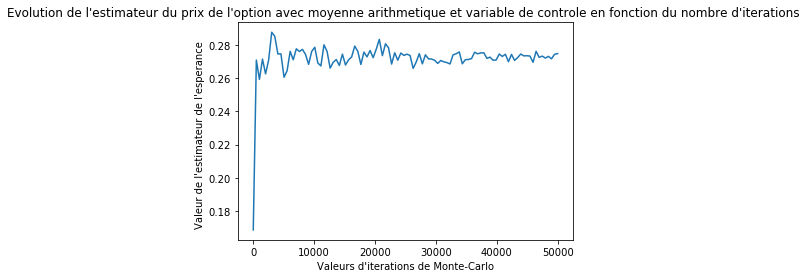

In [18]:
#trace de la courbe d'evolution de l'estimation
#du prix avec moyenne arithmetique et reduction
#de variance
#en fonction du nombre d'iterations de Monte Carlo
vecteur_x=np.linspace(1,50001,100)
vecteur_y=[]

for i in range(100):
    vecteur_y.append(reductionVariance(K,sigma,r,S0,T,an,int(vecteur_x[i])))
plt.plot(vecteur_x,vecteur_y,linewidth=1.5, linestyle="-", label=("Trajectoire de l'estimateur de l'esperance"))
plt.ylabel("Valeur de l'estimateur de l'esperance  ")
plt.xlabel("Valeurs d'iterations de Monte-Carlo")
plt.title("Evolution de l'estimateur du prix de l'option avec moyenne arithmetique et variable de controle en fonction du nombre d'iterations ")
plt.show()

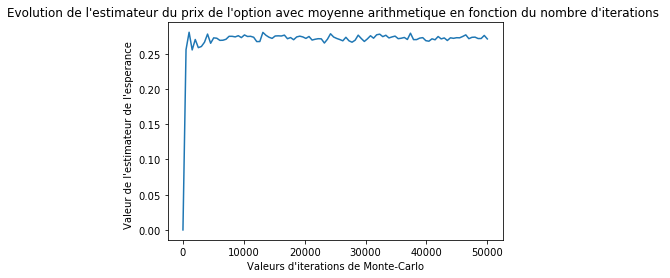

In [17]:
#trace de la courbe d'evolution de l'estimation
#du prix avec moyenne arithmetique sans reduction
#de variance
#en fonction du nombre d'iterations de Monte Carlo

vecteur_x=np.linspace(1,50001,100)
vecteur_y=[]

for i in range(100):
    vecteur_y.append(estimateurMonteCarlo(realisationsMonteCarloArith(K,sigma,r,S0,T,an,int(vecteur_x[i]))))
plt.plot(vecteur_x,vecteur_y,linewidth=1.5, linestyle="-", label=("Trajectoire de l'estimateur de l'esperance"))

plt.ylabel("Valeur de l'estimateur de l'esperance  ")
plt.xlabel("Valeurs d'iterations de Monte-Carlo")
plt.title("Evolution de l'estimateur du prix de l'option avec moyenne arithmetique en fonction du nombre d'iterations ")
plt.show()